<h1>T4 - Traçado de Raios<h3/>

<p></p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, sqrt
import sys

TOL = sys.float_info.epsilon
print(TOL)

2.220446049250313e-16


In [2]:
def vetor(x, y, z):
    return  np.array([x, y, z], dtype = np.float)

def dot(u, v):
    return (u[0] * v[0] + u[1] * v[1] + u[2] * v[2])

def norma(u):
    return sqrt(dot(u, u))

def unitario(v):
    s = norma(v)
    
    if (s > TOL):
        return v/s
    
    else:
        return None

def ang(v1, v2):
    num = dot(v1, v2)
    den = norm(v1) * norm(v2)
    
    return np.arccos(num/den) * 180 / np.pi if den > TOL else 0

def reflete(v, n):
    r = 2 * dot(v, n) * n - v
    return r

def cross(u, v):
    return vetor(u[1] * v[2] - u[2] * v[1], u[2] * v[0] - u[0] * v[2], u[0] * v[1] - u[1] * v[0]) 

In [34]:
class Camera:
    def __init__(self, fov, w, h, dfocal, eye, at, up):
        self.fov = fov
        self.w = w
        self.h = h
        self.dfocal = dfocal
        
        self.a = 2 * dfocal * np.tan(fov * np.pi / 360)
        self.b = self.a * w / h
        self.eye = eye
        
        self.ze = unitario(at - eye)
        self.xe = unitario(cross(self.ze, up))
        self.ye = cross(self.ze, self.xe)
        self.img = np.full(shape = (h, w, 3), fill_value = 0.43, dtype = np.float)
    
    def ray_to(self, x_im, y_im):
        dx = self.b * (x_im / self.w - 0.5)
        dy = self.a * (y_im / self.h - 0.5)
        dz = self.dfocal
        
        ray = dx * self.xe + dy * self.ye + dz * self.ze
        
        return ray
    
    def get_eye(self):
        return self.eye

    def pixel (self, x_im, y_im, rgb):
        self.img[y_im, x_im, :] = rgb
    
    def get_pixel(self, x, y):
        return self.img[y, x, :]
    
    def set_pixel(self, x, y, rgb):
        self.img[y, x, :] = rgb
        
    def get_w(self):
        return self.w
    
    def get_h(self):
        return self.h
    
    def imshow(self):
        self.img[self.img > 1] = 1
        
        plt.figure(figsize = (8, 4))
        plt.imshow(self.img)
        plt.show()
    
    def show(self):
        print("CAMERA:")
        print("fov =", self.fov, "d =", self.dfocal)
        print("(w, h) = (", self.w, ",", self.h, ")")
        print("(b, a) = (", self.b, ",", self.a, ")")
        print("xe =", self.xe)
        print("ye =", self.ye)
        print("ze =", self.ze)

In [35]:
eye = vetor(100, 40, 40)
at = vetor(0, 0, 0)
up = vetor(0, 1, 0)
camera = Camera(90, 300, 300, 30, eye, at, up)
camera.show()

CAMERA:
fov = 90 d = 30
(w, h) = ( 300 , 300 )
(b, a) = ( 59.999999999999986 , 59.99999999999999 )
xe = [ 0.37139068  0.         -0.92847669]
ye = [ 0.32325409 -0.93743687  0.12930164]
ze = [-0.87038828 -0.34815531 -0.34815531]


In [36]:
class Poligono:
    def __init__(self, pp, pn, material):
        self.pp = pp
        self.pn = pn
        self.ni = None
        self.material = material
    
    def show(self):
        print("POLIGONO:")
        for i in range(len(self.pp)):
            print(f'Plano {i}: ponto = {self.pp[i]}, normal = {self.pn[i]}')
        
        self.material.show()
    
    def intercepta(self, origem, direcao):
        te = 0
        ts = np.inf
        obji = None
        
        for i in range(len(self.pp)):
            pn = self.pn[i]
            pp = self.pp[i]
            num = dot(pp - origem, pn)
            den = dot(direcao, pn)
            
            if den < -TOL:
                t = num / den
                
                if t > te:
                    te = t
                    obji = self
                    self.ni = pn
                
            elif den > TOL:
                t = num / den
                ts = t if t < ts else ts
                obji = self
            
            if ts < te:
                te = np.inf
                obji = None
                break
        
        return te, obji
    
    def get_mat(self):
        return self.material
    
    def normal(self, ponto):
        return self.ni

In [37]:
class Caixa(Poligono):
    def __init__(self, pmin, pmax, material):
        super().__init__([pmin, pmin, pmin, pmax, pmax, pmax], 
                         [vetor(-1, 0 , 0), vetor(0, -1, 0), vetor(0, 0, -1), 
                          vetor(1, 0 , 0), vetor(0, 1, 0), vetor(0, 0, 1)], material)

In [38]:
class Esfera:
    def __init__(self, raio, centro, material):
        self.raio = raio
        self.centro = centro
        self.material = material
        
    def show(self):
        print("ESFERA:")
        print(f'raio = {self.raio}')
        print(f'centro = {self.centro}')
        self.material.show()
    
    def intercepta(self, origem, direcao):
        a = dot(direcao, direcao)
        b = 2 * dot(direcao, origem - self.centro)
        c = dot(origem - self.centro, origem - self.centro) - self.raio**2
        delta = b**2 - 4 * a * c
        
        if delta > TOL:
            raiz = sqrt(delta)
            t1 = (-b - raiz) / (2 * a)
            t2 = (-b + raiz) / (2 * a)
            t = t1 if t1 < t2 else t2
            
            if t > 0:
                return t, self
            else:
                return np.inf, None
        else:
            return np.inf, None
     
    def normal(self, ponto):
        return unitario(ponto - self.centro)
    
    def get_mat(self):
        return self.material

In [39]:
class Material:
    def __init__(self, kd, ks, ns, espelhamento, opacidade):
        self.kd = kd
        self.ks = ks
        self.ns = ns
        self.espelhamento = espelhamento
        self.opacidade = opacidade
        
    def show(self):
        print("MATERIAL:")
        print("Cor Difusa = ", self.kd)
        print("Cor Especular = ", self.ks)
        print("Coeficiente Especular = ", self.ns)
        print("Espelhamento = ", self.espelhamento)
        print("Opacidade = ", self.opacidade)
    
    def get_phong(self):
        return self.kd, self.ks, self.ns
    
    def get_espelhamento(self):
        return self.espelhamento
    
    def get_opacidade(self):
        return self.opacidade

In [49]:
azul_metalico = Material(vetor(0, 0, 1), vetor(1, 1, 1), 50, 0, 1)
amarelo_fosco = Material(vetor(0.7, 0.7, 0), vetor(0, 0, 0), 1, 0, 1)
amarelo_espelho = Material(vetor(0.7, 0.7, 0), vetor(0, 0, 0), 1, 0.5, 1)
azul_metalico.show()
amarelo_fosco.show()
amarelo_espelho.show()

MATERIAL:
Cor Difusa =  [0. 0. 1.]
Cor Especular =  [1. 1. 1.]
Coeficiente Especular =  50
Espelhamento =  0
Opacidade =  1
MATERIAL:
Cor Difusa =  [0.7 0.7 0. ]
Cor Especular =  [0. 0. 0.]
Coeficiente Especular =  1
Espelhamento =  0
Opacidade =  1
MATERIAL:
Cor Difusa =  [0.7 0.7 0. ]
Cor Especular =  [0. 0. 0.]
Coeficiente Especular =  1
Espelhamento =  0.5
Opacidade =  1


In [50]:
esfera = Esfera(25, vetor(0, 20, 0), azul_metalico)
esfera.show()

ESFERA:
raio = 25
centro = [ 0. 20.  0.]
MATERIAL:
Cor Difusa =  [0. 0. 1.]
Cor Especular =  [1. 1. 1.]
Coeficiente Especular =  50
Espelhamento =  0
Opacidade =  1


In [51]:
piso = Caixa(vetor(-80, -50, -50), vetor(50, -45, 50), amarelo_fosco)
parede = Caixa(vetor(-80, -50, -60), vetor(50, 50, -50), amarelo_espelho)
piso.show()
parede.show()

POLIGONO:
Plano 0: ponto = [-80. -50. -50.], normal = [-1.  0.  0.]
Plano 1: ponto = [-80. -50. -50.], normal = [ 0. -1.  0.]
Plano 2: ponto = [-80. -50. -50.], normal = [ 0.  0. -1.]
Plano 3: ponto = [ 50. -45.  50.], normal = [1. 0. 0.]
Plano 4: ponto = [ 50. -45.  50.], normal = [0. 1. 0.]
Plano 5: ponto = [ 50. -45.  50.], normal = [0. 0. 1.]
MATERIAL:
Cor Difusa =  [0.7 0.7 0. ]
Cor Especular =  [0. 0. 0.]
Coeficiente Especular =  1
Espelhamento =  0
Opacidade =  1
POLIGONO:
Plano 0: ponto = [-80. -50. -60.], normal = [-1.  0.  0.]
Plano 1: ponto = [-80. -50. -60.], normal = [ 0. -1.  0.]
Plano 2: ponto = [-80. -50. -60.], normal = [ 0.  0. -1.]
Plano 3: ponto = [ 50.  50. -50.], normal = [1. 0. 0.]
Plano 4: ponto = [ 50.  50. -50.], normal = [0. 1. 0.]
Plano 5: ponto = [ 50.  50. -50.], normal = [0. 0. 1.]
MATERIAL:
Cor Difusa =  [0.7 0.7 0. ]
Cor Especular =  [0. 0. 0.]
Coeficiente Especular =  1
Espelhamento =  0.5
Opacidade =  1


In [52]:
class Luz:
    def __init__(self, posicao, intensidade):
        self.posicao = posicao
        self.intensidade = intensidade
    
    def show(self):
        print("LUZ:")
        print(f'Posicao = {self.posicao}')
        print(f'Intensidade = {self.intensidade}')
    
    def get_pos(self):
        return self.posicao
    
    def get_int(self):
        return self.intensidade

In [53]:
luz = Luz(vetor(60, 120, 40), vetor(0.8, 0.8, 0.8))
luz.show()

LUZ:
Posicao = [ 60. 120.  40.]
Intensidade = [0.8 0.8 0.8]


In [54]:
class Cena:
    def __init__(self, camera, objetos, materiais, luzes, ambiente):
        self.camera = camera
        self.objetos = objetos
        self.materiais = materiais
        self.luzes = luzes
        self.ambiente = ambiente
    
    def show(self):
        print("CENA:")
        
        self.camera.show()
        
        for obj in self.objetos:
            obj.show()
        
        for mat in self.materiais:
            mat.show()
        
        for luz in self.luzes:
            luz.show()
        
        print("Ambiente = ", self.ambiente)
    
    def sombra(self,objeto, origem, direcao):
        ti = np.inf
        obji = None
                
        for obj in self.objetos:
            if obj is not objeto:
                t, objx = obj.intercepta(origem, direcao)
                
                if t > TOL and t < 1:
                    return True
        
        return False
    
    def shade(self, objeto, origem, direcao, ponto, normal):
        kd, ks, ns = objeto.get_mat().get_phong()
        cor = self.ambiente * kd
        
        for luz in self.luzes:
            dir2 = luz.get_pos() - ponto
            na_sombra = self.sombra(objeto, ponto, dir2)
            if na_sombra:
                continue
            vluz = unitario(dir2)
            cosseno = dot(vluz, normal)
            
            if cosseno > TOL:
                # Difusa
                cor += luz.get_int() * kd * cosseno
                
                # Especular
                rluz = reflete(vluz, normal)
                cosseno2 = dot(rluz, -unitario(direcao))
                
                if cosseno2 > TOL:
                    cor += luz.get_int() * ks * cosseno2 ** ns
        
        # Recursão nos raios
        espelhamento = objeto.get_mat().get_espelhamento()
        dir_espelhada = reflete(-unitario(direcao), normal)
        if espelhamento > TOL:
            rgb_espelhado, obji = self.trace(ponto, dir_espelhada)
            if obji:
                cor = (1 - espelhamento) * cor + espelhamento * rgb_espelhado
            
        return cor
    
    def trace(self, origem, direcao):
        ti = np.inf
        obji = None
                
        for obj in self.objetos:
            t, objx = obj.intercepta(origem, direcao)
            if t < ti:
                ti = t
                obji = objx
                
        if obji and ti > TOL:
            ponto = origem + ti * direcao
            normal = obji.normal(ponto)
                    
            rgb = self.shade(obji, origem, direcao, ponto, normal)
            return rgb, obji
            
        else:
            return None, None
    
    def render(self):
        w = self.camera.get_w()
        h = self.camera.get_h()
        origem = self.camera.get_eye()
        
        for y in range(h):           
            for x in range(w):
                direcao = self.camera.ray_to(x, y)
                rgb, obji = self.trace(origem, direcao)
                
                if obji:
                    cor = self.camera.get_pixel(x, y)
                    self.camera.set_pixel(x, y, cor + rgb)

In [55]:
objetos = [esfera, piso, parede]
materiais = [azul_metalico, amarelo_fosco, amarelo_espelho]
luzes = [luz]
ambiente = vetor(0.1, 0.1, 0.1)
cena = Cena(camera, objetos, materiais, luzes, ambiente)
cena.show()

CENA:
CAMERA:
fov = 90 d = 30
(w, h) = ( 300 , 300 )
(b, a) = ( 59.999999999999986 , 59.99999999999999 )
xe = [ 0.37139068  0.         -0.92847669]
ye = [ 0.32325409 -0.93743687  0.12930164]
ze = [-0.87038828 -0.34815531 -0.34815531]
ESFERA:
raio = 25
centro = [ 0. 20.  0.]
MATERIAL:
Cor Difusa =  [0. 0. 1.]
Cor Especular =  [1. 1. 1.]
Coeficiente Especular =  50
Espelhamento =  0
Opacidade =  1
POLIGONO:
Plano 0: ponto = [-80. -50. -50.], normal = [-1.  0.  0.]
Plano 1: ponto = [-80. -50. -50.], normal = [ 0. -1.  0.]
Plano 2: ponto = [-80. -50. -50.], normal = [ 0.  0. -1.]
Plano 3: ponto = [ 50. -45.  50.], normal = [1. 0. 0.]
Plano 4: ponto = [ 50. -45.  50.], normal = [0. 1. 0.]
Plano 5: ponto = [ 50. -45.  50.], normal = [0. 0. 1.]
MATERIAL:
Cor Difusa =  [0.7 0.7 0. ]
Cor Especular =  [0. 0. 0.]
Coeficiente Especular =  1
Espelhamento =  0
Opacidade =  1
POLIGONO:
Plano 0: ponto = [-80. -50. -60.], normal = [-1.  0.  0.]
Plano 1: ponto = [-80. -50. -60.], normal = [ 0. -1.  0.]


In [56]:
cena.render()

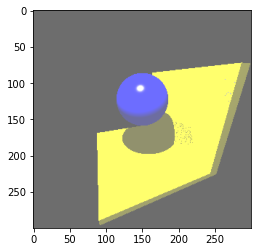

In [57]:
camera.imshow()